# IN - Analysis Notebook - Logistic - Regression

In [0]:
from pyspark.sql.functions import col, udf, expr, pandas_udf, to_date, date_trunc, concat_ws, collect_list, struct, broadcast, row_number
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, StringType, StructType, StructField, DoubleType, DateType, TimestampType, ArrayType, FloatType, LongType
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import numpy as np
from pyspark.sql import Window
from pyspark.sql.functions import date_add, to_timestamp, PandasUDFType
from pyspark.sql.functions import col, unix_timestamp, from_unixtime
import pandas as pd
from prophet import Prophet
# import tensorflow
# import xgboost
# import graphframes
from pyspark.ml.feature import Imputer
from sklearn.preprocessing import LabelEncoder
# import numpy as np
import math
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import mlflow

print("Welcome to the W261 final project!") 

Welcome to the W261 final project!


# Connect to team storage blob

In [0]:
# The following blob storage is accessible to team members only (read and write)
# access key is valid til TTL
# after that you will need to create a new SAS key and authenticate access again via DataBrick command line
blob_container  = "team-3-2-project261"       # The name of your container created in https://portal.azure.com
storage_account = "fall2024team32"  # The name of your Storage account created in https://portal.azure.com
secret_scope    = "scope_team_3_2"           # The name of the scope created in your local computer using the Databricks CLI
secret_key      = "key_team_3_2"             # The name of the secret key created in your local computer using the Databricks CLI
team_blob_url   = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"  #points to the root of your team storage bucket


# the 261 course blob storage is mounted here.
mids261_mount_path      = "/mnt/mids-w261"

# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# IN check the listing in team blob
display(dbutils.fs.ls(f"{team_blob_url}"))

path,name,size,modificationTime
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_cancelled_data/,12m_cancelled_data/,0,1731754303000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_diverted_data/,12m_diverted_data/,0,1731754311000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_duplicates_removed/,12m_duplicates_removed/,0,1733298522000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_final_data/,12m_final_data/,0,1731755226000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_final_data_deduped/,12m_final_data_deduped/,0,1731805979000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_mean_year_month_destination/,12m_mean_year_month_destination/,0,1731754740000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_mean_year_month_origin/,12m_mean_year_month_origin/,0,1731754736000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_null_summary/,12m_null_summary/,0,1731754630000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_sorted_data/,12m_sorted_data/,0,1731754292000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_summary_statistics/,12m_summary_statistics/,0,1731756196000



# Know your mount
Here is the mounting for this class, your source for the original data! Remember, you only have Read access, not Write! Also, become familiar with `dbutils` the equivalent of `gcp` in DataProc

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path,name,size,modificationTime
dbfs:/mnt/mids-w261/2014_flights/,2014_flights/,0,1731598242000
dbfs:/mnt/mids-w261/HW5/,HW5/,0,0
dbfs:/mnt/mids-w261/OTPW_12M/,OTPW_12M/,0,1721794777000
dbfs:/mnt/mids-w261/OTPW_12M_2015.parquet/,OTPW_12M_2015.parquet/,0,1721930011000
dbfs:/mnt/mids-w261/OTPW_12M_2015_cleaned_sorted.parquet/,OTPW_12M_2015_cleaned_sorted.parquet/,0,1731788138000
dbfs:/mnt/mids-w261/OTPW_12M_2015_sorted.parquet/,OTPW_12M_2015_sorted.parquet/,0,1731652365000
dbfs:/mnt/mids-w261/OTPW_1D_CSV/,OTPW_1D_CSV/,0,0
dbfs:/mnt/mids-w261/OTPW_36M/,OTPW_36M/,0,0
dbfs:/mnt/mids-w261/OTPW_3M/,OTPW_3M/,0,1721832995000
dbfs:/mnt/mids-w261/OTPW_3M_2015.csv,OTPW_3M_2015.csv,1500620247,1679772070000


In [0]:
dbutils.fs.help()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:464)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:571)
	at com.data

# Gather data to prepare for model

In [0]:
# If the ordered data is already in the blob
# data_encoded_scaled_ordered = (spark.read.parquet(f"{team_blob_url}/data_encoded_scaled_ordered_3m/"))

# retrieve the encoded scaled and ordered train and test data from the blob
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_3m/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_3m_v4/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_12m/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_12m_v5/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v2/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v3/"))
train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v4/"))

# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_3m/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_3m_v4/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_12m/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_12m_v5/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v2/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v3/"))
test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v4/"))

scaled_cols = (spark.read.parquet(f"{team_blob_url}/scaled_cols_60m_v4/"))

# Pipeline for CV and Grid Search

## CV to split train_val_df to train_df and test_df

In [0]:
from pyspark.sql.functions import row_number, col
from pyspark.sql.window import Window
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Undersample function from Muthum
def delay_groups_fractions(df, source, tgt_label):
    print(f'Dataset: {source}')
    total_count = df.count()
    label_counts_df = df.groupBy(tgt_label).count()

    # Find the minimum class count
    min_count = label_counts_df.agg(F.min('count')).collect()[0][0]

    # Calculate percentage and fraction of min count
    grouped_df = label_counts_df.\
                    withColumn("percentage", (label_counts_df['count'] / total_count) * 100).\
                    withColumn("fraction", min_count/label_counts_df['count'])

    grouped_df.show()

    # Assuming df is your DataFrame with 'key_column' and 'value_column'
    fractions = dict(grouped_df.select(tgt_label, "fraction").\
                    rdd.map(lambda x: (x[0], x[1])).collect())

    return fractions

# From AG (mostly, with my modification)
def split_folds_train_val(df, leakage_pct=0.02, val_pct=0.1, n_folds=6, delay_col="DEP_DELAY_GROUP_NEW", version='NA', data_month_label='NA'):
    # Split train, test
    train_val_rows = df.count()

    train_val_df = df.withColumn("row_id", row_number().over(Window.partitionBy().orderBy("two_hours_prior_depart_UTC")))

    # Split folds.
    fold_size = train_val_rows // n_folds
    val_size = int(fold_size * val_pct)
    splits = []

    train_start_idx = 0
    for fold in range(1, n_folds): # IN: added start from 1
        # Define train and validation boundaries
        if fold >1:
            train_start_idx = val_end_idx #IN: add to do block train_df instead of expanding window train_df
        train_end_idx = (fold) * fold_size # IN: remove 1+ to make sure the last train_end_idx is not the end of the entire window so that it leaves room for validation set for this split
        leakage_cnt = int(fold_size * leakage_pct)
        val_start_idx = train_end_idx - leakage_cnt
        val_end_idx = train_end_idx + val_size + leakage_cnt

        # Avoid caching too much. It runs out of memory.
        train_df = train_val_df.filter(
            (col("row_id") >= train_start_idx) & (
            col("row_id") < train_end_idx))

        # Get validation set
        val_df = train_val_df.filter(
            (col("row_id") >= val_start_idx) & (col("row_id") < val_end_idx)
        )

        print(f"Fold: {fold}, train_start_idx: {train_start_idx}, train_end_idx: {train_end_idx}, val_start_idx: {val_start_idx}, val_end_idx: {val_end_idx}")

        # Show brief summary.
        train_fraction = delay_groups_fractions(train_df, "Train", delay_col)

        # Commented out to speed it up a little more.
        val_fraction = delay_groups_fractions(val_df, "Val", delay_col)

        # Safety bounds checking. We "shouldn't" need to do it for max(0.0, v).
        train_fraction = {k: min(1.0, v) for k, v in train_fraction.items()}

        # Undersample train data for imbalance treatment.
        train_df = train_df.sampleBy(delay_col, train_fraction, seed=20)

        # Save split data into blob
        
        train_df.write.mode("overwrite").parquet(f"{team_blob_url}/IN_{data_month_label}_fold_{fold}_train_{version}")
        val_df.write.mode("overwrite").parquet(f"{team_blob_url}/IN_{data_month_label}_fold_{fold}_val_{version}")

        # Append everything.
        splits.append((train_df, val_df))

    return splits

In [0]:
def get_pipeline_lr():
    # Defaults
    label_col = "DEP_DELAY_GROUP_NEW"
    features_col = "final_features_mod"
    # regularization_params = [0.001, 0.01, 0.1, 0.5, 1.0]
    # elastic_net_params = [0.0, 0.25, 0.5, 0.75, 1.0]
    regularization_params = [0, 0.01, 0.1]
    elastic_net_params = [0.0, 0.5, 1.0]

    # Define Logistic Regression.
    lr = LogisticRegression(featuresCol=features_col, labelCol=label_col)

    # Define parameter grid search.
    param_grid = (
        ParamGridBuilder()
        .addGrid(lr.regParam, regularization_params)
        .addGrid(lr.elasticNetParam, elastic_net_params)
        .build()
    )

    # Class we want to improve.
    focused_class = 2.0

    # Recall
    f_beta = 2.0

    evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol="prediction",
        metricLabel=focused_class,
        metricName="fMeasureByLabel",
        beta=f_beta,
    )

    # NOTE: We can put the assembler in the pipeline, but it consumed too much memory when training.
    return Pipeline(stages=[lr]), param_grid, evaluator


def train_and_evaluate_chunk(train_assembled_df, val_assembled_df, pipeline_with_params, evaluator):
    pipeline_model = pipeline_with_params.fit(train_assembled_df)

    # NOTE: Evaluating the train set won't fit in memory.

    # Evaluate on the validation set
    val_pred = pipeline_model.transform(val_assembled_df)

    return evaluator.evaluate(val_pred)


def evaluate_ema(ema_val_f_beta, fold_f_beta, alpha=0.3):
    ema_val_f_beta = alpha * fold_f_beta + (1 - alpha) * ema_val_f_beta
    return ema_val_f_beta

def evaluate_w_weight(fold_idx, ema_val_f_beta, fold_f_beta):
    weight_dic = {0:0.1, 1:0.15, 2:0.2, 3:0.25, 4:0.3}
    return ema_val_f_beta + weight_dic[fold_idx]*fold_f_beta

def train_pipeline(splits, pipeline, param_grid, evaluator):
    best_params = None
    best_val_f_beta = float("-inf")

    param_list = []
    f_beta_list = []

    # NOTE: `splits` is assembled already to save memory.

    # Smoothing factor.
    alpha = 0.3

    # Iterate over each parameter combination
    for params in param_grid:
        # Set the parameters in the pipeline.
        pipeline_with_params = pipeline.copy(params)

        # Define exponential moving average.
        ema_val_f_beta = 0

        # Perform k-fold cross-validation
        for fold_idx, (train_assembled_df, val_assembled_df) in enumerate(splits):
            print(f"Training Fold {fold_idx + 1}")

            # Train each chunk.
            fold_f_beta = train_and_evaluate_chunk(
                train_assembled_df, val_assembled_df, pipeline_with_params, evaluator
            )

            if fold_idx == 0:
                # Initialize:
                ema_val_f_beta = evaluate_w_weight(fold_idx, 0.0, fold_f_beta)
                
            else:
                # Calculate EMA.
                ema_val_f_beta = evaluate_w_weight(fold_idx, ema_val_f_beta, fold_f_beta)
            
            print(
                f"Fold {fold_idx + 1} F-beta: {fold_f_beta}, Updated EMA: {ema_val_f_beta}"
            )

        print("----------------------------------------------")
        print("----------------------------------------------")
        print(f"params: {params}, ema_val_f_beta: {ema_val_f_beta}\n\n")

        if ema_val_f_beta > best_val_f_beta:
            best_val_f_beta = ema_val_f_beta
            best_params = params
        
        # IN: to keep the results for all params
        param_list.append(params)
        f_beta_list.append(ema_val_f_beta)

    return ({
        "best_params": best_params,
        "best_val_f_beta": best_val_f_beta,
    }, param_list, f_beta_list)


## Split the CV data

In [0]:
# Generate splits for CV
# version, data_month_label = 'v4', '12m'
version, data_month_label = 'v3_2', '60m'

splits = split_folds_train_val(df=train_val_df, version=version, data_month_label=data_month_label)

In [0]:
## if the split already exists, load the split from blob
# version, data_month_label = 'v4', '12m'
# version, data_month_label = 'v2', '60m'
version, data_month_label = 'v3', '60m'

# IN_12m_fold_1_train_v4/

splits = []
for fold in range(1,5+1):
    print (f'Loading fold_{fold}:')
    train_df_f = spark.read.parquet(f"{team_blob_url}/IN_{data_month_label}_fold_{fold}_train_{version}")
    val_df_f = spark.read.parquet(f"{team_blob_url}/IN_{data_month_label}_fold_{fold}_val_{version}")
    splits.append((train_df_f, val_df_f))


Loading fold_1:
Loading fold_2:
Loading fold_3:
Loading fold_4:
Loading fold_5:


## Run Grid Search

In [0]:
# Assemble final features and create relevant columns for each CV split
cols_to_be_assembled_mod = ['scaled_features'] + list({x for x in train_val_df.columns if '_Encoded' in x} - {'origin_type_Encoded', 'dest_type_Encoded'} - {'ORIGIN_Encoded', 'DEST_Encoded'})\
    + ['origin_code_vector', 'dest_code_vector']

assembler = VectorAssembler(inputCols=cols_to_be_assembled_mod, outputCol='final_features_mod')

assembled_CV_splits = [
    (
        assembler.transform(train_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod"),
        assembler.transform(val_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")
    )
    for train_df, val_df in splits
]

assembled_test_df = assembler.transform(test_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")

In [0]:
# from 60m data output for reference:
new_features = ['DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'origin_code_vector',
 'dest_code_vector',
 'In_degree_same_origin_past_3hr',
 'Out_degree_same_dest_past_3hr']


scaled_cols = ['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_origin_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_dest_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded']


cols_to_be_assembled_mod= ['scaled_features',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

all_mod_features =['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_origin_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_dest_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
# Total mod features
all_mod_features = (scaled_cols + cols_to_be_assembled_mod)
all_mod_features.remove('scaled_features')
all_mod_features

['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_origin_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_dest_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
mlflow.spark.autolog()

pipeline_mod, param_grid, evaluator = get_pipeline_lr()

best_params_and_metrics_dic, param_list, f_beta_list = train_pipeline(assembled_CV_splits, pipeline_mod, param_grid, evaluator)

best_params = best_params_and_metrics_dic['best_params']
best_metrics = best_params_and_metrics_dic['best_val_f_beta']

cv_results = pd.DataFrame(columns=[param.name for param in best_params.keys()]+['f_beta'], index=range(len(param_list)))
for i in range(len(param_list)):
    # print(param_list[i], f_beta_list[i])
    cv_results.iloc[i,:] = np.array(list(param_list[i].values())+[f_beta_list[i]])

2024/12/12 23:20:16 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.3177610707922298, Updated EMA: 0.03177610707922298
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.5201020278275513, Updated EMA: 0.10979141125335568
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.4440771448668058, Updated EMA: 0.19860684022671682
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.2402454961262018, Updated EMA: 0.25866821425826725
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.5367921925545494, Updated EMA: 0.41970587202463205
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, ema_val_f_beta: 0.41970587202463205


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.3177610707922298, Updated EMA: 0.03177610707922298
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.5201129261247737, Updated EMA: 0.10979304599793901
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.4440771448668058, Updated EMA: 0.1986084749713002
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.2402454961262018, Updated EMA: 0.2586698490028506
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.5367921925545494, Updated EMA: 0.4197075067692154
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}, ema_val_f_beta: 0.4197075067692154


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.3177610707922298, Updated EMA: 0.03177610707922298
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.5201059435783537, Updated EMA: 0.10979199861597602
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.4440771448668058, Updated EMA: 0.1986074275893372
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.2402454961262018, Updated EMA: 0.2586688016208876
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.5367921925545494, Updated EMA: 0.41970645938725243
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0}, ema_val_f_beta: 0.41970645938725243


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.3168593064966122, Updated EMA: 0.03168593064966122
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.5164843799879185, Updated EMA: 0.109158587647849
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.44253709051080353, Updated EMA: 0.1976660057500097
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.23302105375940854, Updated EMA: 0.25592126918986186
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.5352147946910311, Updated EMA: 0.4164857075971712
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, ema_val_f_beta: 0.4164857075971712


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.33148981681126927, Updated EMA: 0.03314898168112693
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.5068081302889248, Updated EMA: 0.10917020122446565
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.4274406114950014, Updated EMA: 0.19465832352346593
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.2781250502161302, Updated EMA: 0.2641895860774985
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.5083515059200846, Updated EMA: 0.41669503785352385
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}, ema_val_f_beta: 0.41669503785352385


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.32763389706008944, Updated EMA: 0.03276338970600894
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.49959382615759546, Updated EMA: 0.10770246362964825
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.40618679583827344, Updated EMA: 0.18893982279730293
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.2681210072012614, Updated EMA: 0.2559700745976183
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.49005285813056176, Updated EMA: 0.4029859320367868
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0}, ema_val_f_beta: 0.4029859320367868


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.3143748363520451, Updated EMA: 0.03143748363520451
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.5058608841468427, Updated EMA: 0.1073166162572309
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.435526448283147, Updated EMA: 0.19442190591386033
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.2041470605198074, Updated EMA: 0.2454586710438122
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.5270344488577229, Updated EMA: 0.4035690057011291
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, ema_val_f_beta: 0.4035690057011291


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.27645841120151804, Updated EMA: 0.027645841120151806
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.4940201597820979, Updated EMA: 0.10174886508746649
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.38855702800088726, Updated EMA: 0.17946027068764395
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.23768190654832516, Updated EMA: 0.23888074732472525
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.42533240785552356, Updated EMA: 0.3664804696813823
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}, ema_val_f_beta: 0.3664804696813823


Training Fold 1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 1 F-beta: 0.0, Updated EMA: 0.0
Training Fold 2


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 2 F-beta: 0.554029542109305, Updated EMA: 0.08310443131639575
Training Fold 3


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 3 F-beta: 0.0, Updated EMA: 0.08310443131639575
Training Fold 4


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 4 F-beta: 0.0, Updated EMA: 0.08310443131639575
Training Fold 5


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Fold 5 F-beta: 0.0, Updated EMA: 0.08310443131639575
----------------------------------------------
----------------------------------------------
params: {Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0}, ema_val_f_beta: 0.08310443131639575




In [0]:
cv_results = pd.DataFrame(columns=[param.name for param in best_params.keys()]+['f_beta'], index=range(len(param_list)))
for i in range(len(param_list)):
    # print(param_list[i], f_beta_list[i])
    cv_results.iloc[i,:] = np.array(list(param_list[i].values())+[f_beta_list[i]])

In [0]:
cv_results

,regParam,elasticNetParam,f_beta
0,0.0,0.0,0.419706
1,0.0,0.5,0.419708
2,0.0,1.0,0.419706
3,0.01,0.0,0.416486
4,0.01,0.5,0.416695
5,0.01,1.0,0.402986
6,0.1,0.0,0.403569
7,0.1,0.5,0.36648
8,0.1,1.0,0.083104


In [0]:
best_params

{Param(parent='LogisticRegression_33bf74d2a821', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
 Param(parent='LogisticRegression_33bf74d2a821', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}

## Save CV results

In [0]:
# Save CV related dataframes to blob storage
# res_saving_version = 'v3'  # 'v2'
# res_data_month_label = '12m'

res_saving_version = 'v2'  # 'v1','v2'
res_data_month_label = '60m'

spark.createDataFrame(pd.DataFrame([best_params])).write.mode('overwrite').parquet(f'{team_blob_url}/IN_best_params_LR_{res_data_month_label}_{res_saving_version}')
spark.createDataFrame(cv_results).write.mode('overwrite').parquet(f'{team_blob_url}/IN_cv_results_LR_{res_data_month_label}_{res_saving_version}')

# Train final model section

##  Gather the data in preparation of modeling

In [0]:
# If the ordered data is already in the blob
# data_encoded_scaled_ordered = (spark.read.parquet(f"{team_blob_url}/data_encoded_scaled_ordered_3m/"))

# retrieve the encoded scaled and ordered train and test data from the blob
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_3m/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_3m_v4/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_12m/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_12m_v5/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v2/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v3/"))
train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v4/"))

# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_3m/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_3m_v4/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_12m/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_12m_v5/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v2/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v3/"))
test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v4/"))

scaled_cols = (spark.read.parquet(f"{team_blob_url}/scaled_cols_60m_v4/"))

In [0]:
print((train_val_df).select('YEAR').distinct().collect())
# print((val_df).select('MONTH').distinct().collect())
print((test_df).select('YEAR').distinct().collect())

[Row(YEAR=2018), Row(YEAR=2015), Row(YEAR=2017), Row(YEAR=2016)]
[Row(YEAR=2019)]


In [0]:
display(scaled_cols)
scaled_cols = scaled_cols.toPandas()['0'].tolist()  #IN: note: the order is not reliable, in fact it is already changed, so can only used as reference of content; for order please refer to the encoding notebook print out

In [0]:
# Splitting out the scaled columns which do not have newly engineered features

# for 60m dataset
new_features = ['DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'origin_code_vector',
 'dest_code_vector',
 'In_degree_same_origin_past_3hr',
 'Out_degree_same_dest_past_3hr']

# for 60m dataset
scaled_cols = ['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_origin_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_dest_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded']

In [0]:
# spark.catalog.clearCache()

## Create sub-set of features which do not include new features for comparison analysis later

In [0]:
# Run this only if we want to study the model without new features
# Split out the original numerical columns from scaled_features (for both train_val_df and test_df)
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# train_val_df.select('scaled_features').show(10)
# display(train_val_df.withColumn('scaled_', vector_to_array('scaled_features')).select([col('scaled_')[i].alias(f'scaled_{scaled_cols[i]}') for i in range(len(scaled_cols)) if scaled_cols[i] not in new_features]).limit(10))

train_val_df = train_val_df.withColumn('scaled_', vector_to_array('scaled_features'))
test_df = test_df.withColumn('scaled_', vector_to_array('scaled_features'))

for i, col_name in enumerate(scaled_cols):
    if col_name not in new_features:
        train_val_df = train_val_df.withColumn(f'scaled_{scaled_cols[i]}', col('scaled_')[i]).cache()
        test_df = test_df.withColumn(f'scaled_{scaled_cols[i]}', col('scaled_')[i]).cache()
    # else:
    #     train_val_df = train_val_df.drop(col('scaled_')[i]).cache()
    #     test_df = test_df.drop(col('scaled_')[i]).cache()

# test_df = test_df.withColumn('scaled_', vector_to_array('scaled_features')).select([col('scaled_')[i].alias(f'scaled_{scaled_cols[i]}') for i in range(len(scaled_cols)) if scaled_cols[i] not in new_features]).cache()

scaled_original_num_cols = [f'scaled_{col}' for col in scaled_cols if col not in new_features]

display(train_val_df.select(scaled_original_num_cols).limit(10))

scaled_DISTANCE,scaled_ELEVATION,scaled_HourlyAltimeterSetting,scaled_HourlyDryBulbTemperature,scaled_HourlyPrecipitation,scaled_HourlyRelativeHumidity,scaled_HourlySeaLevelPressure,scaled_HourlyStationPressure,scaled_HourlyVisibility,scaled_HourlyWindDirection,scaled_HourlyWindSpeed,scaled_dest_type_Encoded,scaled_origin_type_Encoded
0.13784056508577194,0.0791397483849031,0.5547947934609297,0.7283236994219653,0.0,0.6161616161616162,0.44765327299594154,0.8317006790704911,0.10058338547750634,0.638888888888889,0.006705409029950827,1.0,1.0
0.1394550958627649,0.08564263855831351,0.5479453218030192,0.722543352601156,0.0,0.6363636363636365,0.44765327299594154,0.8245769099728012,0.10058338547750634,0.6666666666666667,0.009834599910594547,1.0,1.0
0.2768920282542886,0.012198231893913636,0.5924655811762984,0.7514450867052023,9.302475518938246E-4,0.8787878787878789,0.49630471046929847,0.8904719864314983,0.10058338547750634,0.3055555555555556,0.0022351363433169426,1.0,1.0
0.4131180625630676,0.001147568854131248,0.6059797148265597,0.699421965317919,2.7106074715622843E-4,0.6767676767676768,0.595667633882769,0.91807657045454,0.09997988094399447,0.5277777777777778,0.0049172999552972736,1.0,1.0
0.39374369323915237,0.001147568854131248,0.61040257449391,0.699421965317919,1.8450775989146243E-4,0.7575757575757577,0.595667633882769,0.91807657045454,0.09997988094399447,0.5277777777777778,0.004470272686633885,1.0,1.0
0.2036326942482341,0.12708262495749748,0.5616436119172707,0.722543352601156,0.0,0.686868686868687,0.4584838440023191,0.7996438030529128,0.10058338547750634,0.5833333333333334,0.006705409029950827,1.0,1.0
0.3977800201816347,0.020061203672220338,0.6072709609514385,0.6878612716763005,2.1101667221614488E-4,0.7575757575757577,0.5920574435473098,0.9038290322591603,0.09997988094399447,0.5599128723144532,0.0022351363433169426,1.0,1.0
0.13905146316851666,0.08564263855831351,0.5479453218030192,0.722543352601156,0.0,0.6363636363636365,0.44765327299594154,0.8245769099728012,0.10058338547750634,0.6666666666666667,0.009834599910594547,1.0,1.0
0.032492431886982844,0.05686841210472628,0.5890408453473431,0.7398843930635838,0.0,0.8181818181818182,0.48736467811259276,0.8521816638398955,0.10058338547750634,0.5555555555555556,0.003576218149307108,1.0,1.0
0.21553985872855702,0.0036127167630057807,0.6284663070216343,0.7745664739884393,0.0036900212489746308,0.8181818181818182,0.559566419101577,0.9127337860922858,0.09997988094399447,0.0,0.0,1.0,1.0


## Train the final model

In [0]:
# Utile functions for training (if not run before)
# Undersample function from Muthum
def delay_groups_fractions(df, source, tgt_label):
    print(f'Dataset: {source}')
    total_count = df.count()
    label_counts_df = df.groupBy(tgt_label).count()

    # Find the minimum class count
    min_count = label_counts_df.agg(F.min('count')).collect()[0][0]

    # Calculate percentage and fraction of min count
    grouped_df = label_counts_df.\
                    withColumn("percentage", (label_counts_df['count'] / total_count) * 100).\
                    withColumn("fraction", min_count/label_counts_df['count'])

    grouped_df.show()

    # Assuming df is your DataFrame with 'key_column' and 'value_column'
    fractions = dict(grouped_df.select(tgt_label, "fraction").\
                    rdd.map(lambda x: (x[0], x[1])).collect())

    return fractions

def performance_per_label(input_pred, split_name, results_summary, f_beta):
  preAndlabels = input_pred.select(['prediction', 'DEP_DELAY_GROUP_NEW']).rdd.map(lambda x: (float(x['prediction']), float(x['DEP_DELAY_GROUP_NEW'])))

  # print(preAndlabels)

  # instantiate metrics object
  metrics = MulticlassMetrics(preAndlabels)

  # stats by class
  labels = [0.0, 1.0, 2.0]
  for label in sorted(labels):
    # print (label)
    print('\n%s Class %s F%s-Measure = %s'% (split_name, label, f_beta, metrics.fMeasure(label, f_beta)))
    print('%s Class %s precision = %s'% (split_name, label, metrics.precision(label)))
    print('%s Class %s recall = %s'% (split_name, label, metrics.recall(label)))

    results_summary.loc[f'Class {int(label)} F{f_beta}-Measure', split_name] = metrics.fMeasure(label, f_beta)
    results_summary.loc[f'CLass {int(label)} precision', split_name] =  metrics.precision(label)
    results_summary.loc[f'Class {int(label)} recall', split_name] = metrics.recall(label)

  return results_summary


def confusion_matrix_sklearn(y_orig, y_pred):
    """
    To plot the confusion_matrix with percentages
    prediction:  predicted values
    original:    original values
    """
    cm = confusion_matrix(y_orig, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(3, 3)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


In [0]:
# Train the final model with train_val_df
def train_final_model(train_val_df, test_df, chosen_params=None):
    # undersample
    # undersample for imbalance treatment - on train data only
    fractions = delay_groups_fractions(train_val_df, 'Train_val', 'DEP_DELAY_GROUP_NEW')
    train_val_df = train_val_df.sampleBy("DEP_DELAY_GROUP_NEW", fractions, seed=20).cache()
    delay_groups_fractions(train_val_df, 'Train_val', 'DEP_DELAY_GROUP_NEW')
    delay_groups_fractions(test_df, 'Test', 'DEP_DELAY_GROUP_NEW')

    '''fit LR'''
    mod = LogisticRegression(featuresCol='final_features_mod', labelCol='DEP_DELAY_GROUP_NEW')
    # mod = mod.copy(chosen_params)
    if chosen_params is not None:
        param_grid_cho = (
            ParamGridBuilder()
            .addGrid(mod.regParam, [chosen_params['regParam']])
            .addGrid(mod.elasticNetParam, [chosen_params['elasticNetParam']])
            .build()
            )
        mod = mod.copy(param_grid_cho[0])
        # param_map = ParamMap(chosen_params)
    res_mod = mod.fit(train_val_df)

    # Evaluate F1 score for each split of data
    focuse_class = 2.0
    f_beta = 2.0
    # evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DELAY_GROUP_NEW', predictionCol='prediction', metricName="f1")
    evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DELAY_GROUP_NEW', predictionCol='prediction', 
                                                metricLabel=focuse_class, metricName="fMeasureByLabel", beta=f_beta)

    # Get F-beta scores for each split
    # training 
    train_pred = res_mod.transform(train_val_df).cache()
    train_fmeasure = evaluator.evaluate(train_pred)
    print(f'Training F-{f_beta} Score is {train_fmeasure}')

    # # validation 
    # val_pred = res_mod.transform(val_df).cache()
    # val_fmeasure = evaluator.evaluate(val_pred)
    # print(f'Validation F-{f_beta} Score is {val_fmeasure}')

    # testing 
    test_pred = res_mod.transform(test_df).cache()
    # test_pred = test_pred.fillna(0.0)
    test_fmeasure = evaluator.evaluate(test_pred)
    print(f'Test F-{f_beta} Score is {test_fmeasure}')

    # putting results together
    results_summary = pd.DataFrame({'Train': [train_fmeasure], 'Test': [test_fmeasure]},
                            index=[f'F{f_beta} score'])
    
    # Get per class F1 scores for each split
    split_names = ['Train', 'Test']
    pred_list = [train_pred, test_pred]

    for i in range(len(split_names)):
        split_name = split_names[i]
        pred_s = pred_list[i]
        results_summary = performance_per_label(pred_s, split_name, results_summary, float(f_beta))
    
    print()
    print(results_summary)
    print()
    
    # Generate the confusion matrix (for test split only)
    pred_conf_matrix = test_pred
    y_pred = pred_conf_matrix.select('prediction').collect()
    y_orig = pred_conf_matrix.select('DEP_DELAY_GROUP_NEW').collect()
    confusion_matrix_sklearn(y_orig, y_pred)

    return res_mod, results_summary, train_pred, test_pred


In [0]:
# If not set up before:

#for >60m data set
# if to include all features:
cols_to_be_assembled_mod =['scaled_features',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded', #IN: only for >=12m
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded', #IN: only for >12m
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

#  # if to include only original features (no new features):
# cols_to_be_assembled_mod = \
# scaled_original_num_cols + \
#  ['DEP_TIME_BLK_Encoded',
#  'DAY_OF_WEEK_Encoded',
#  'MONTH_Encoded',
#  'QUARTER_Encoded', #IN: only for >=12m
#  'OP_UNIQUE_CARRIER_Encoded',
#  'YEAR_Encoded', #IN: only for >12m
#  'ARR_TIME_BLK_Encoded',
#  'DAY_OF_MONTH_Encoded',
#  'origin_code_vector',
#  'dest_code_vector']

assembler = VectorAssembler(inputCols=cols_to_be_assembled_mod, outputCol='final_features_mod')

# assemble and select useful columns for test_df
assembled_test_df = assembler.transform(test_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")

In [0]:
cols_to_be_assembled_mod

['scaled_features',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
best_params_lr ={'regParam': 0.01,'elasticNetParam': 0.5} # IN for LR

Dataset: Train_val
+-------------------+--------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|   count|        percentage|          fraction|
+-------------------+--------+------------------+------------------+
|                  1| 5362115|22.469998250880995|0.8011821827767588|
|                  2| 4296031|18.002562245630784|               1.0|
|                  0|14205296|59.527439503488225|0.3024246027678691|
+-------------------+--------+------------------+------------------+

Dataset: Train_val
+-------------------+-------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|  count|        percentage|          fraction|
+-------------------+-------+------------------+------------------+
|                  1|4297209|33.345676660441974|0.9991636431925931|
|                  2|4296031|  33.3365355627886|0.9994376204454763|
|                  0|4293615| 33.31778777676943|               1.0|
+-------------------+-------+------------------+------------------+

D

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Training F-2.0 Score is 0.5086334775892775
Test F-2.0 Score is 0.48433335794771604


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Train Class 0.0 F2.0-Measure = 0.5826618933317207
Train Class 0.0 precision = 0.49200614376615415
Train Class 0.0 recall = 0.6107978940822594

Train Class 1.0 F2.0-Measure = 0.40496719758930766
Train Class 1.0 precision = 0.4556359878687739
Train Class 1.0 recall = 0.39401318390611206

Train Class 2.0 F2.0-Measure = 0.5086334775892775
Train Class 2.0 precision = 0.5568924610680154
Train Class 2.0 recall = 0.49784789728007084


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Test Class 0.0 F2.0-Measure = 0.6414787383633016
Test Class 0.0 precision = 0.7375314827205423
Test Class 0.0 recall = 0.6212514963543367

Test Class 1.0 F2.0-Measure = 0.3471587971435067
Test Class 1.0 precision = 0.32103748549566025
Test Class 1.0 recall = 0.3543670934515676

Test Class 2.0 F2.0-Measure = 0.48433335794771604
Test Class 2.0 precision = 0.37509817672182666
Test Class 2.0 recall = 0.5223637327638306

                         Train      Test
F2.0 score            0.508633  0.484333
Class 0 F2.0-Measure  0.582662  0.641479
CLass 0 precision     0.492006  0.737531
Class 0 recall        0.610798  0.621251
Class 1 F2.0-Measure  0.404967  0.347159
CLass 1 precision     0.455636  0.321037
Class 1 recall        0.394013  0.354367
Class 2 F2.0-Measure  0.508633  0.484333
CLass 2 precision     0.556892  0.375098
Class 2 recall        0.497848  0.522364



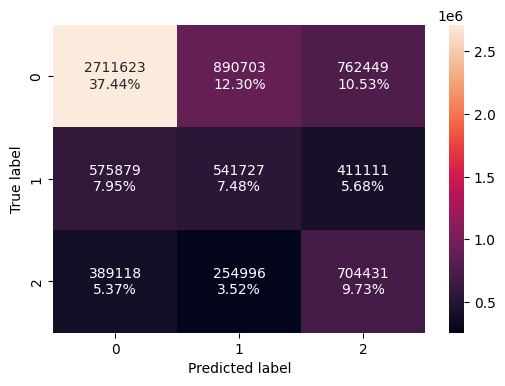

In [0]:
# Train the last model with CV chosen params  # re-train for 12/12/2024 to save model on workspace properly
# chosen_params = best_params_v3
chosen_params = best_params_lr
# chosen_params = None
assembled_train_val_df = assembler.transform(train_val_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")
final_mod, results_summary, train_pred, test_pred = train_final_model(assembled_train_val_df, 
                                               assembled_test_df, chosen_params)


In [0]:
# as of 12/12/2024 retrain
results_summary

,Train,Test
F2.0 score,0.508633,0.484333
Class 0 F2.0-Measure,0.582662,0.641479
CLass 0 precision,0.492006,0.737531
Class 0 recall,0.610798,0.621251
Class 1 F2.0-Measure,0.404967,0.347159
CLass 1 precision,0.455636,0.321037
Class 1 recall,0.394013,0.354367
Class 2 F2.0-Measure,0.508633,0.484333
CLass 2 precision,0.556892,0.375098
Class 2 recall,0.497848,0.522364


Dataset: Train_val
+-------------------+--------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|   count|        percentage|          fraction|
+-------------------+--------+------------------+------------------+
|                  1| 5362115|22.469998250880995|0.8011821827767588|
|                  2| 4296031|18.002562245630784|               1.0|
|                  0|14205296|59.527439503488225|0.3024246027678691|
+-------------------+--------+------------------+------------------+

Dataset: Train_val
+-------------------+-------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|  count|        percentage|          fraction|
+-------------------+-------+------------------+------------------+
|                  1|4295548| 33.32717822544205|               1.0|
|                  2|4296031| 33.33092559995233|0.9998875706436942|
|                  0|4297445|33.341896174605615|0.9995585749206796|
+-------------------+-------+------------------+------------------+

D

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Training F-2.0 Score is 0.5087440619709248
Test F-2.0 Score is 0.4843932252461154


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Train Class 0.0 F2.0-Measure = 0.5827457322652171
Train Class 0.0 precision = 0.4919399218622207
Train Class 0.0 recall = 0.6109385925823367

Train Class 1.0 F2.0-Measure = 0.4042795291412148
Train Class 1.0 precision = 0.4555553367929589
Train Class 1.0 recall = 0.39321478889305855

Train Class 2.0 F2.0-Measure = 0.5087440619709248
Train Class 2.0 precision = 0.5565666003696884
Train Class 2.0 recall = 0.49804552155233517


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Test Class 0.0 F2.0-Measure = 0.6422194920684113
Test Class 0.0 precision = 0.7373983249723155
Test Class 0.0 recall = 0.6221438676678638

Test Class 1.0 F2.0-Measure = 0.3464231820880237
Test Class 1.0 precision = 0.3213253981096336
Test Class 1.0 recall = 0.35332242658386087

Test Class 2.0 F2.0-Measure = 0.4843932252461154
Test Class 2.0 precision = 0.3750651441262223
Test Class 2.0 recall = 0.5224668068177184

                         Train      Test
F2.0 score            0.508744  0.484393
Class 0 F2.0-Measure  0.582746  0.642219
CLass 0 precision     0.491940  0.737398
Class 0 recall        0.610939  0.622144
Class 1 F2.0-Measure  0.404280  0.346423
CLass 1 precision     0.455555  0.321325
Class 1 recall        0.393215  0.353322
Class 2 F2.0-Measure  0.508744  0.484393
CLass 2 precision     0.556567  0.375065
Class 2 recall        0.498046  0.522467



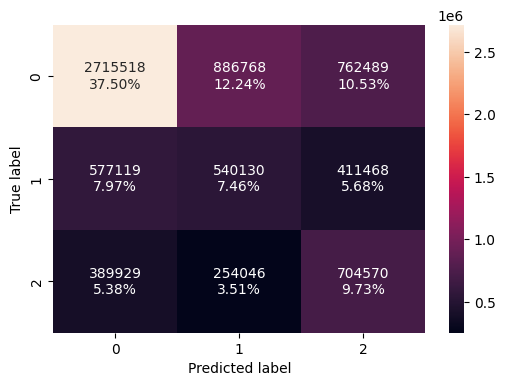

In [0]:
# Train the last model with CV chosen params # result as of 12/8/2024
# chosen_params = best_params_v3
chosen_params = best_params_lr
# chosen_params = None
assembled_train_val_df = assembler.transform(train_val_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")
final_mod, results_summary = train_final_model(assembled_train_val_df, 
                                               assembled_test_df, chosen_params)


In [0]:
# result as of 12/8/2024
results_summary

,Train,Test
F2.0 score,0.508744,0.484393
Class 0 F2.0-Measure,0.582746,0.642219
CLass 0 precision,0.491940,0.737398
Class 0 recall,0.610939,0.622144
Class 1 F2.0-Measure,0.404280,0.346423
CLass 1 precision,0.455555,0.321325
Class 1 recall,0.393215,0.353322
Class 2 F2.0-Measure,0.508744,0.484393
CLass 2 precision,0.556567,0.375065
Class 2 recall,0.498046,0.522467


In [0]:
display(assembled_train_val_df.dtypes)

_1,_2
DEP_DELAY_GROUP_NEW,int
final_features_mod,vector


## Save important models

In [0]:
import pickle
# import joblib
# model_save_version = 'v3'
# month_label = '12m'
# model_save_version = 'v1_no_new_features'
model_save_version = 'v2_with_new_features' # 'v3_with_new_features', 'v2_with_new_features'
month_label = '60m'

# save model
# IN this worked - using Using MLlib's Native Save/Load Functionality
path_workspace = '/Workspace/Users/sha.na.in.12@berkeley.edu/'
# final_mod.write().overwrite().save(f"{path_workspace}test_IN_xgboost_model_{model_save_version}_{month_label}")
final_mod.write().overwrite().save(f"{path_workspace}IN_LR_model_{model_save_version}_{month_label}.pkl") 

# save results
pickle.dump(results_summary, open(f'IN_LR_results_summary_{model_save_version}_{month_label}.pkl', 'wb'))

# save to blob for assemble purpose
test_pred.write.mode("overwrite").parquet(f"{team_blob_url}/IN_LR_test_pred_w_new_features_60m")

## Compare model with and without features

In [0]:
## IN: Load LR model with new features from workspace 
import pickle
from pyspark.ml.classification import LogisticRegressionModel

path_workspace = '/Workspace/Users/sha.na.in.12@berkeley.edu/'
model_save_version = 'v2_with_new_features'
month_label = '60m'

## load the model later
model_loaded = LogisticRegressionModel.load(f"{path_workspace}IN_LR_model_{model_save_version}_{month_label}.pkl") #IN: wont work without .pkl, still doesn't show in workspace but loadable

# load the results
results_summary_loaded_w_new_features = pickle.load(open(f'IN_LR_results_summary_{model_save_version}_{month_label}.pkl', 'rb'))

In [0]:
# result as of 12/8/2024 - LR with new features 
results_summary_loaded_w_new_features

,Train,Test
F2.0 score,0.508744,0.484393
Class 0 F2.0-Measure,0.582746,0.642219
CLass 0 precision,0.491940,0.737398
Class 0 recall,0.610939,0.622144
Class 1 F2.0-Measure,0.404280,0.346423
CLass 1 precision,0.455555,0.321325
Class 1 recall,0.393215,0.353322
Class 2 F2.0-Measure,0.508744,0.484393
CLass 2 precision,0.556567,0.375065
Class 2 recall,0.498046,0.522467


In [0]:
# load models without new features from workspace 
import pickle
from pyspark.ml.classification import LogisticRegressionModel

path_workspace = '/Workspace/Users/sha.na.in.12@berkeley.edu/'
model_save_version = 'v1_no_new_features'
month_label = '60m'

# load the results
results_summary_loaded_wo_new_features = pickle.load(open(f'IN_LR_results_summary_{model_save_version}_{month_label}.pkl', 'rb'))

In [0]:
# result as of 12/8/2024 - LR without new features 
results_summary_loaded_wo_new_features

,Train,Test
F2.0 score,0.500649,0.451409
Class 0 F2.0-Measure,0.487617,0.555926
CLass 0 precision,0.477258,0.719832
Class 0 recall,0.490277,0.525984
Class 1 F2.0-Measure,0.371835,0.306821
CLass 1 precision,0.437269,0.323228
Class 1 recall,0.358426,0.302976
Class 2 F2.0-Measure,0.500649,0.451409
CLass 2 precision,0.447501,0.276176
Class 2 recall,0.515969,0.536513


## Feature importance analysis

In [0]:
important_num_features = ['DEP_DELAY_NEW',
'TAXI_OUT',
'TAXI_IN',
'ARR_DELAY_NEW',
'CRS_ELAPSED_TIME',
'ACTUAL_ELAPSED_TIME',
'DISTANCE',
'ELEVATION',
'HourlyAltimeterSetting',
# 'HourlyDewPointTemperature',
'HourlyDryBulbTemperature',
'HourlyPrecipitation',
'HourlyRelativeHumidity',
'HourlySeaLevelPressure',
'HourlyStationPressure',
'HourlyVisibility',
# 'HourlyWetBulbTemperature',
'HourlyWindDirection',
'HourlyWindSpeed']

features_not_directly_available = [
'DEP_DELAY_NEW',
'ARR_DELAY_NEW',
'TAXI_OUT',
'TAXI_IN',
'CANCELLED',
'DIVERTED',
'ACTUAL_ELAPSED_TIME',
'Actual_vs_scheduled_elapsed_time'
]

In [0]:
# # for 12m dataset
# new_features = ['DEP_DELAY_COUNT_3600sec',
#  'DEP_DELAY_COUNT_7200sec',
#  'ARR_DELAY_COUNT_3600sec',
#  'ARR_DELAY_COUNT_7200sec',
#  'CANCELLED_DELAY_COUNT_3600sec',
#  'CANCELLED_DELAY_COUNT_7200sec',
#  'InDegreeOrigin',
#  'OutDegreeOrigin',
#  'TotalDegreeOrigin',
#  'Lag_same_flight_DEP_DELAY_NEW',
#  'Avg_DEP_DELAY_NEW_other_flights',
#  'Avg_TAXI_OUT_other_flights',
#  'Last_DEP_DELAY_NEW_other_flights',
#  'Last_TAXI_OUT_other_flights',
#  'Avg_ARR_DELAY_NEW_other_flights',
#  'Avg_TAXI_IN_other_flights',
#  'Last_ARR_DELAY_NEW_other_flights',
#  'Last_TAXI_IN_other_flights',
#  'Weekly_avg_DEP_DELAY_NEW_hat',
#  'origin_code_vector',
#  'dest_code_vector']

 # for 60m dataset
new_features = ['DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'origin_code_vector',
 'dest_code_vector',
 'Out_degree_same_origin_past_3hr', # corrected from In_degree_same_origin_past_3hr
 'In_degree_same_dest_past_3hr'] # corrected from Out_degree_same_dest_past_3hr

In [0]:
scaled_cols_w_right_order = sorted(list(set(important_num_features).union(set(new_features))- {'ACTUAL_ELAPSED_TIME','CRS_ELAPSED_TIME'} - set(features_not_directly_available)
                   -set(['origin_code_vector', 'dest_code_vector']))+ ['origin_type_Encoded', 'dest_type_Encoded']) 

# for 60m dataset
all_mod_features_w_right_order =  scaled_cols_w_right_order +\
['DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
all_mod_features_w_right_order

['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_dest_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_origin_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
cat_encoded_col_dic = {'DEP_TIME_BLK_Encoded':19, 'ARR_TIME_BLK_Encoded':19, 
                       'DAY_OF_WEEK_Encoded':7, 'QUARTER_Encoded':4, 
                       'YEAR_Encoded':4, # 'YEAR_Encoded':4 for 60m dataset for train_val_df 
                       'MONTH_Encoded':12,  # 'MONTH_Encoded':10 for 12 month dataset for up to train_val_df; 12 for 60m dataset
                       'OP_UNIQUE_CARRIER_Encoded':19, # 14 for 12m; 19 for 60m dataset
                       'DAY_OF_MONTH_Encoded':31,
                       'origin_code_vector':9, 'dest_code_vector':9} # 8 for 12m; 9 for 60m dataset

In [0]:
len(all_mod_features_w_right_order)

len(sum([[x] if x not in cat_encoded_col_dic.keys() 
 else [f'{x}_{i}' for i in range(cat_encoded_col_dic[x])] for x in all_mod_features_w_right_order],[]))

all_mod_col_names = sum([[x] if x not in cat_encoded_col_dic.keys() 
 else [f'{x}_{i}' for i in range(cat_encoded_col_dic[x])] for x in all_mod_features_w_right_order],[])

## For logistic regression

In [0]:
# get the intended model run from experiment
import mlflow
# logged_model = 'runs:/e6c3288241ab41e6a09d752d811242dc/model' # IN logistic regression (v1 without feature)
logged_model = 'runs:/9d9474b92b664c2383ba7c8d511ad15c/model'# IN logistic regression (v2 with feature)


# Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model = mlflow.spark.load_model(logged_model)
mod_to_examine = loaded_model.stages[-1]

2024/12/12 21:56:11 INFO mlflow.spark: 'runs:/86bc276513d6462fb483fbe6c4eba429/model' resolved as 'dbfs:/databricks/mlflow-tracking/3948917746254176/86bc276513d6462fb483fbe6c4eba429/artifacts/model'


In [0]:
# for logistic regression
coefficients_mod = mod_to_examine.coefficientMatrix
intercept_mod = mod_to_examine.interceptVector 

In [0]:
import pandas as pd
pd.DataFrame(coefficients_mod.toArray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159
0,0.000000,-0.188246,-9.814545,-0.159071,0.000000,0.000000,-1.156219,-2.852684,-0.435810,0.0,0.000000,0.0,0.000000,-0.052491,0.0,0.0,0.862329,0.0,-0.833336,0.683213,-3.128589,0.000000,0.000000,0.0,-0.278957,-0.215215,0.000000,0.338709,0.307274,0.184776,0.000000,0.0,0.000502,-0.002933,0.0,0.030708,0.0,0.000000,-0.046617,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006631,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.625034,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.015159,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.007013
2,0.293051,0.908024,20.050802,1.364020,1.066006,1.793253,0.470165,1.330329,0.000000,0.0,-0.376902,0.0,2.588482,0.223057,0.0,0.0,0.000000,0.0,0.000000,-1.374936,20.875117,0.178809,0.290723,0.0,0.070628,0.000000,0.000000,-0.699060,-0.442995,-0.205792,0.064841,0.0,-0.031001,0.000000,0.0,-0.102229,0.0,0.009016,0.000000,0.088385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.025801,0.0,0.0,0.01569,0.0,-0.041378


In [0]:
# guess the order of the columns 
input_cols_guessed = all_mod_col_names

In [0]:
import pandas as pd
coefficients_mod_pdf = pd.DataFrame(coefficients_mod.toArray(), columns=input_cols_guessed, index=['class_0', 'class_1', 'class_2']).T.sort_values(by='class_2', ascending=False)
intercept_mod_pdf = pd.DataFrame(intercept_mod.toArray(), columns=['intercept'], index=['class_0', 'class_1', 'class_2']).T

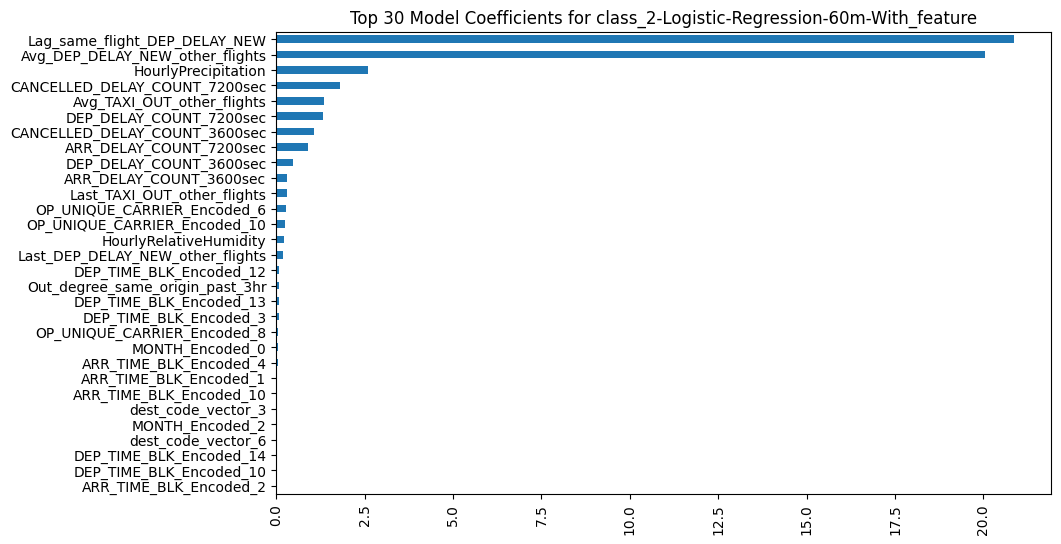

In [0]:
import matplotlib.pyplot as plt
feat_label = 'Without_feature'
feat_label = 'With_feature'

coefficients_mod_pdf['class_2'][:30].sort_values(ascending=True).plot(kind='barh', title=f'Top 30 Model Coefficients for class_2-Logistic-Regression-60m-{feat_label}', figsize=(10,6))
plt.xticks(rotation=90)
plt.show()

In [0]:
coefficients_mod_pdf['class_2'][:30].to_frame()

,class_2
Lag_same_flight_DEP_DELAY_NEW,20.875117
Avg_DEP_DELAY_NEW_other_flights,20.050802
HourlyPrecipitation,2.588482
CANCELLED_DELAY_COUNT_7200sec,1.793253
Avg_TAXI_OUT_other_flights,1.364020
DEP_DELAY_COUNT_7200sec,1.330329
CANCELLED_DELAY_COUNT_3600sec,1.066006
ARR_DELAY_COUNT_7200sec,0.908024
DEP_DELAY_COUNT_3600sec,0.470165
ARR_DELAY_COUNT_3600sec,0.293051
